Segmenting customers based on their purchasing behavior helps businesses understand different customer types and tailor their marketing strategies accordingly. One common approach to segment customers is using RFM analysis, which stands for Recency, Frequency, and Monetary value. Here's how you can segment customers based on these dimensions and provide insights into each segment.

Steps for Customer Segmentation using RFM Analysis
1. Recency: How recently a customer made a purchase.
2. Frequency: How often a customer makes a purchase.
3. Monetary: How much money a customer spends on purchases.

**OBJECTIVE**
To perform customer segmentation using RFM metrics and clustering algorithms for strategic business insights.

In [10]:
#importing libraries
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
#load dataset
df=pd.read_csv("master_dataset.csv")

In [12]:
df['order_purchase_timestamp']=pd.to_datetime(df['order_purchase_timestamp'])
#df['customer_unique_id']=pd.to_numeric(df["customer_unique_id"])

In [ ]:
print(df['customer_unique_id'].dtype)

object


In [40]:
df.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
review_id                           997
review_score                        997
review_comment_title             105154


In [14]:
#calculating rfm
max_date=df['order_purchase_timestamp'].max()
rfm=df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp":"max",
    "order_id":"nunique",
    "payment_value":"sum"
}).reset_index()

rfm.columns=['customer_id', 'last_purchase', 'frequency', 'monetary']

rfm['recency']=(max_date-rfm['last_purchase']).dt.days

rfm=rfm.drop(columns=['last_purchase'])

rfm.head()

,customer_id,frequency,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,163
2,0000f46a3911fa3c0805444483337064,1,86.22,585
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,369
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,336


In [15]:
#scaling data

scaler=StandardScaler()

scaled_data=scaler.fit_transform(rfm[['frequency', 'monetary', 'recency']])

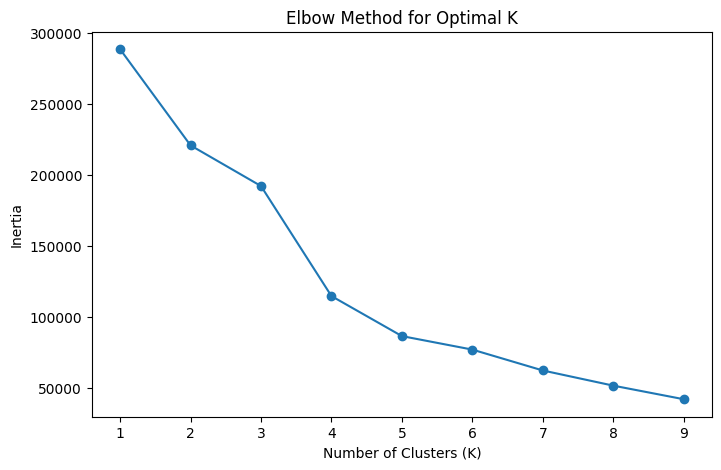

In [16]:

#elbow
inertia = []

for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,10), inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()



The elbow appears at K=4, where inertia reduction slows significantly. Hence K=4 was selected for clustering

In [17]:
#final clustering
model=KMeans(n_clusters=4, random_state=42)
rfm['cluster']=model.fit_predict(scaled_data)

In [18]:
#evaluate
print("Silhouette Score: ", silhouette_score(scaled_data, rfm["cluster"]))

Silhouette Score:  0.5256731162324895


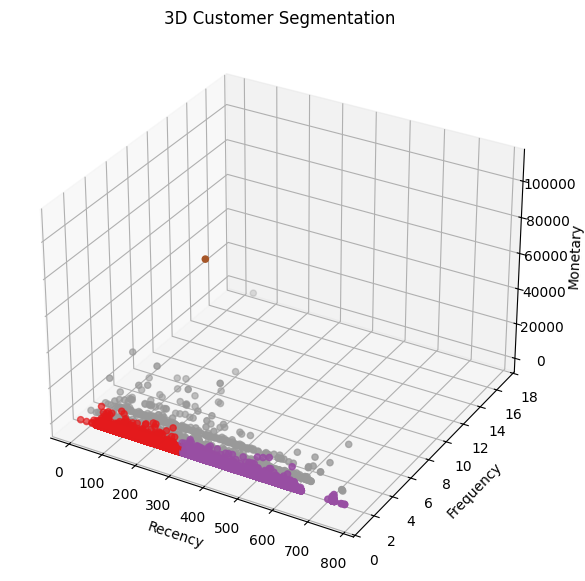

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm["recency"],
    rfm["frequency"],
    rfm["monetary"],
    c=rfm["cluster"],
    cmap="Set1"
)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.title("3D Customer Segmentation")

plt.show()

The 3D visualization highlights clear separation among customer segments based on Recency, Frequency, and Monetary value.

- Cluster 1 represents recent but low-spending customers, likely new or occasional buyers.
- Cluster 2 consists of customers with high recency and low frequency, indicating inactive or at-risk customers.
- Cluster 3 includes moderately active customers with balanced spending patterns.

A small group of high-monetary customers represents VIP customers who contribute significantly to revenue.

The segmentation enables targeted marketing strategies based on purchasing behavior.

In [20]:
rfm.head()

,customer_id,frequency,monetary,recency,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,160,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,163,0
2,0000f46a3911fa3c0805444483337064,1,86.22,585,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,369,1
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,336,1


In [21]:
cluster_summary = rfm.groupby("cluster")[["recency", "frequency", "monetary"]].mean()
cluster_summary

,recency,frequency,monetary
cluster,,,
0,176.821197,1.000000,199.465546
1,437.083371,1.000000,200.774877
2,383.000000,1.000000,109312.640000
3,268.172860,2.109821,614.354482


- Cluster 0: Occasional customers with moderate recency and low spending.
- Cluster 1: Inactive customers with high recency and low engagement.
- Cluster 2: High-value customers contributing significantly to revenue despite low purchase frequency.
- Cluster 3: Loyal customers with relatively higher purchase frequency and moderate spending.

The segmentation highlights that most customers purchase only once, suggesting potential opportunities to improve retention strategies.

In [23]:
import numpy as np

rfm["monetary_log"] = np.log1p(rfm["monetary"])
rfm["frequency_log"] = np.log1p(rfm["frequency"])

In [24]:
rfm_numeric = rfm[["recency","frequency_log","monetary_log"]]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm_numeric)

from sklearn.cluster import KMeans
model = KMeans(n_clusters=4, random_state=42)
rfm["cluster"] = model.fit_predict(scaled)

In [37]:
score_log = silhouette_score(scaled, rfm['cluster'])
print("Silhouette Score after log: ", score_log)

Silhouette Score after log:  0.3769710889889807


In [36]:
cluster_summary = rfm.groupby("cluster")[["recency", "frequency_log", "monetary_log"]].mean()
cluster_summary

,recency,frequency_log,monetary_log
cluster,,,
0,190.433390,0.693147,4.293481
1,471.139560,0.693147,4.591916
2,268.206874,1.128740,5.681166
3,240.759289,0.693147,5.893788


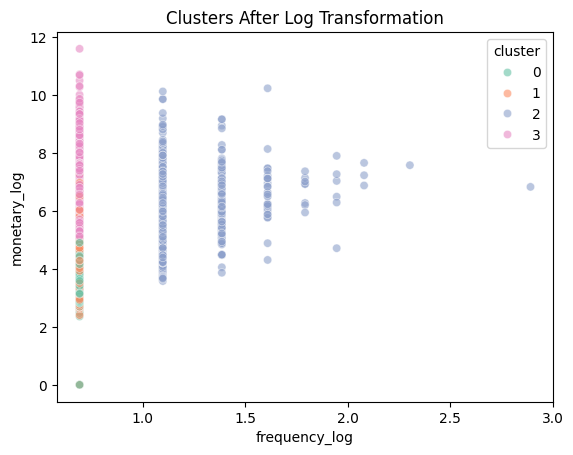

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=rfm,
    x="frequency_log",
    y="monetary_log",
    hue="cluster",
    palette="Set2",
    alpha=0.6
)

plt.title("Clusters After Log Transformation")
plt.show()

After applying log transformation to frequency and monetary variables, cluster separation improved significantly. The transformation reduced skewness and allowed KMeans to identify meaningful customer segments. The four clusters represent occasional customers, inactive customers, loyal customers, and high-value customers.

In [26]:
rfm_scaled_df = pd.DataFrame(
    scaled,
    columns=["recency_scaled","frequency_scaled","monetary_scaled"]
)

rfm_scaled_df["cluster"] = rfm["cluster"]

In [27]:
import plotly.express as px

fig = px.scatter_3d(
    rfm_scaled_df.sample(5000),   # sample for clarity
    x="recency_scaled",
    y="frequency_scaled",
    z="monetary_scaled",
    color="cluster",
    opacity=0.6,
    title="3D Clusters (Scaled Space)"
)

fig.show()

**Using DBscan**

DBSCAN was applied to identify density-based customer groupings and potential outliers, as it does not require pre-specifying the number of clusters.

In [28]:
from sklearn.cluster import DBSCAN

rfm_sample = rfm.sample(10000, random_state=42)

In [ ]:
import numpy as np 

#log for skewness
rfm_sample["frequency_log"] = np.log1p(rfm_sample["frequency"])
rfm_sample["monetary_log"] = np.log1p(rfm_sample["monetary"])

features = rfm_sample[["recency","frequency_log","monetary_log"]]

scaler = StandardScaler()
scaled_sample = scaler.fit_transform(features)

In [30]:

db = DBSCAN(eps=0.8, min_samples=10)
rfm_sample["db_cluster"] = db.fit_predict(scaled_sample)

In [31]:
rfm_sample.head()

,customer_id,frequency,monetary,recency,cluster,monetary_log,frequency_log,db_cluster
15547,2964dcd7e8060025ce0a4a1d7a97fe27,1,403.81,376,3,6.003418,0.693147,0
59000,9cf7324fd017fe2411c1633eb6cfb38d,1,95.11,351,1,4.565493,0.693147,0
54216,9082dcf13bb5feb0e686d709eb35d02c,1,150.84,336,1,5.022827,0.693147,0
60305,a081984f46d03c9d2f878109275c1e09,1,148.06,477,1,5.004349,0.693147,0
58237,9b05e01ea14c37ec8ec1e8ff17b5e37f,1,58.62,252,0,4.087991,0.693147,0


In [32]:
#evaluate
print("Silhouette Score: ", silhouette_score(scaled_sample, rfm_sample["db_cluster"]))

Silhouette Score:  0.6941657359023709


- **KMeans (Original)** produced reasonably well-separated clusters.
- **Log transformation reduced KMeans performance**, indicating that scaling compressed natural separation.
- **DBSCAN achieved the highest silhouette score (0.694)**, indicating strong density-based separation and well-defined cluster boundaries.

This suggests that the dataset contains natural density structures that DBSCAN was able to capture effectively.

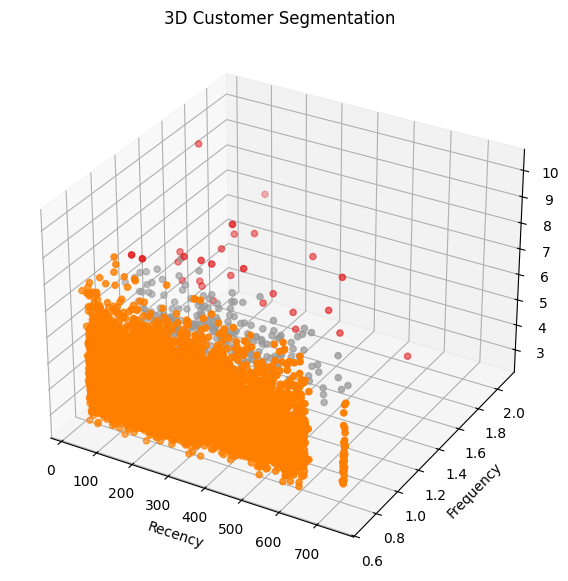

In [33]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm_sample["recency"],
    rfm_sample["frequency_log"],
    rfm_sample["monetary_log"],
    c=rfm_sample["db_cluster"],
    cmap="Set1"
)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.title("3D Customer Segmentation")

plt.show()

- One large dense customer group.
- One smaller but clearly separated cluster.
- A small number of outliers detected automatically.
- Clear density-based grouping rather than forced partitioning.

Unlike KMeans, DBSCAN does not force equal cluster sizes. 
Instead, it groups customers based on density, which makes it robust to skewness and extreme customers.

In [34]:
cluster_summary_dbscan = rfm_sample.groupby("cluster")[["recency", "frequency_log", "monetary_log"]].mean()
cluster_summary_dbscan

,recency,frequency_log,monetary_log
cluster,,,
0,191.059598,0.693147,4.281729
1,469.514101,0.693147,4.595825
2,264.033898,1.125223,5.616067
3,239.933005,0.693147,5.874701


In [39]:
pd.Series(rfm_sample['db_cluster']).value_counts()

db_cluster
 0    9703
 1     269
-1      28
Name: count, dtype: int64

- The dataset is heavily dominated by one large dense customer segment.
- A smaller secondary cluster exists with distinct behavior.
- Only 28 customers were classified as noise, showing that DBSCAN handled outliers effectively.

## Final Model Comparison & Selection

Although DBSCAN achieved the highest silhouette score (0.694), it produced only two primary clusters.

KMeans (k=4), while slightly lower in silhouette score (0.52), provided more granular and actionable customer segments.

### Final Decision:

- DBSCAN is better for detecting natural density structure.
- KMeans is better for business-driven segmentation where multiple actionable groups are required.

Therefore, **KMeans (k=4) is selected as the final model for customer segmentation due to interpretability and strategic usability.**